In [113]:
# AI Theme - Compact Kiwi Visualization Setup
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import yfinance as yf
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
AI_COLORS = {'primary':'#8FBC8F','gold':'#DAA520','crypto':'#FF6347','accent':'#6B8E23','highlight':'#ADFF2F','dark':'#2F4F2F','neutral':'#F0FFF0'}
kiwi_palette = [AI_COLORS['primary'], AI_COLORS['gold'], AI_COLORS['crypto'], AI_COLORS['accent'], AI_COLORS['highlight']]
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette(kiwi_palette)
plt.rcParams.update({'figure.facecolor':AI_COLORS['neutral'],'figure.figsize':[12,8],'axes.facecolor':'white','axes.edgecolor':AI_COLORS['dark'],'axes.grid':True,'axes.titlecolor':AI_COLORS['dark'],'axes.titleweight':'bold','axes.titlesize':16,'axes.labelsize':12,'grid.color':AI_COLORS['primary'],'grid.alpha':0.3,'font.size':11,'xtick.color':AI_COLORS['dark'],'ytick.color':AI_COLORS['dark'],'legend.fontsize':10,'legend.frameon':True,'legend.facecolor':'white','legend.edgecolor':AI_COLORS['primary'],'lines.linewidth':2,'savefig.dpi':300,'savefig.bbox':'tight'})
sns.set_context("notebook", font_scale=1.1)

# The Problem

Portfolio diversification is incredibly important. I wondered, if there would be useful categories found by cluster mdodels that would be hard to find otherwise. Creating useful features that could help define boundaries. We could then use these otherwise hard to see categories as an extra check while putting together a portfolio. Knowing and defining the complex relationships of assets on the markets, in order to group them as shared or related risks. This could prevent putting too much risk in an asset of xyz behavior, and encourage healthy portfolio diversification. It could also be used to monitor the relationship dynamics of the assets over time, and detect if companies begin shifting sectors or becoming too entangled in other assets in your portfolio in real time. Thats the larger picture potential, life dynamic monitoring.

---

# The Data

> **Real Financial Market Data**

This is an **unlabeled dataset** of 225+ diverse financial assets. The goal is to discover natural groupings based on shared risk profiles - will the model find traditional sectors like Tech vs Energy, or uncover complex risk relationships we don't immediately understand?

### Dataset Information:
**Source**: Yahoo Finance (yfinance)  
**Time Period**: 5 years of historical data  
**Date Range**: 2021-11-10 to 2025-03-24

### Asset Universe:
| Category | Count | Examples |
|----------|-------|----------|
| **Large Cap Stocks** | 50 | AAPL, MSFT, GOOGL, NVDA, TSLA |
| **Mid Cap Stocks** | 30 | PLTR, SNOW, COIN, ROKU, ABNB |
| **Energy Stocks** | 20 | XOM, CVX, COP, SLB, EOG |
| **Financial Stocks** | 20 | JPM, GS, BAC, BLK, AXP |
| **Broad Market ETFs** | 20 | SPY, QQQ, IWM, VOO, VTI |
| **Sector ETFs** | 20 | XLK, XLF, XLE, XLV, XLI |
| **Thematic ETFs** | 20 | ARKK, ICLN, HACK, ROBO, JETS |
| **Commodities** | 30 | Gold, Silver, Oil, Copper, Wheat |
| **Cryptocurrencies** | 20 | BTC, ETH, SOL, ADA, DOGE |

### Features Engineered:
| Feature | Description |
|---------|-------------|
| `Mean_Return` | Annualized average return |
| `Volatility` | Annualized standard deviation |
| `Sharpe_Ratio` | Risk-adjusted return metric |
| `Skewness` | Distribution asymmetry |
| `Kurtosis` | Tail risk measure |
| `Downside_Volatility` | Downside risk |
| `Max_Drawdown` | Largest peak-to-trough decline |
| `Percentile_5/95` | Extreme return thresholds |
| `Rolling_Volatility` | 30-day rolling volatility average |
| `Win_Rate` | Percentage of positive days |
| `Gain_Loss_Ratio` | Average gain vs average loss |
| `Correlation_SPY` | Correlation with market (SPY) |
| `Beta_SPY` | Systematic risk vs market |

# Data Aquistion & Scraping
First lets define our universe

In [114]:
#our diverse financial assets
FINANCIAL_ASSETS = [
    # Large Cap US Stocks (50)
    ("AAPL", "Stock", "Tech"), ("MSFT", "Stock", "Tech"), ("GOOGL", "Stock", "Tech"),
    ("AMZN", "Stock", "Tech"), ("NVDA", "Stock", "Tech"), ("META", "Stock", "Tech"),
    ("TSLA", "Stock", "Auto"), ("BRK-B", "Stock", "Financial"), ("V", "Stock", "Financial"),
    ("JNJ", "Stock", "Healthcare"), ("WMT", "Stock", "Retail"), ("JPM", "Stock", "Financial"),
    ("MA", "Stock", "Financial"), ("PG", "Stock", "Consumer"), ("UNH", "Stock", "Healthcare"),
    ("HD", "Stock", "Retail"), ("DIS", "Stock", "Media"), ("BAC", "Stock", "Financial"),
    ("ADBE", "Stock", "Tech"), ("CRM", "Stock", "Tech"), ("NFLX", "Stock", "Media"),
    ("CMCSA", "Stock", "Telecom"), ("PEP", "Stock", "Consumer"), ("COST", "Stock", "Retail"),
    ("CSCO", "Stock", "Tech"), ("AVGO", "Stock", "Tech"), ("INTC", "Stock", "Tech"),
    ("AMD", "Stock", "Tech"), ("QCOM", "Stock", "Tech"), ("TXN", "Stock", "Tech"),
    ("INTU", "Stock", "Tech"), ("AMAT", "Stock", "Tech"), ("BKNG", "Stock", "Travel"),
    ("AMGN", "Stock", "Healthcare"), ("SBUX", "Stock", "Consumer"), ("GILD", "Stock", "Healthcare"),
    ("MDLZ", "Stock", "Consumer"), ("ADP", "Stock", "Tech"), ("ISRG", "Stock", "Healthcare"),
    ("LRCX", "Stock", "Tech"), ("ADI", "Stock", "Tech"), ("REGN", "Stock", "Healthcare"),
    ("PYPL", "Stock", "Financial"), ("MU", "Stock", "Tech"), ("VRTX", "Stock", "Healthcare"),
    ("MRNA", "Stock", "Healthcare"), ("NXPI", "Stock", "Tech"), ("KLAC", "Stock", "Tech"),
    ("MELI", "Stock", "Tech"), ("ASML", "Stock", "Tech"),
    
    # Mid Cap Stocks (30)
    ("ABNB", "Stock", "Travel"), ("COIN", "Stock", "Financial"), ("ROKU", "Stock", "Tech"),
    ("SNAP", "Stock", "Tech"), ("SPOT", "Stock", "Media"), ("SQ", "Stock", "Financial"),
    ("RBLX", "Stock", "Tech"), ("PLTR", "Stock", "Tech"), ("SNOW", "Stock", "Tech"),
    ("NET", "Stock", "Tech"), ("CRWD", "Stock", "Tech"), ("ZS", "Stock", "Tech"),
    ("DDOG", "Stock", "Tech"), ("MDB", "Stock", "Tech"), ("TEAM", "Stock", "Tech"),
    ("ZM", "Stock", "Tech"), ("DOCU", "Stock", "Tech"), ("UBER", "Stock", "Tech"),
    ("LYFT", "Stock", "Tech"), ("DASH", "Stock", "Tech"), ("PINS", "Stock", "Tech"),
    ("ETSY", "Stock", "Retail"), ("W", "Stock", "Retail"), ("CHWY", "Stock", "Retail"),
    ("PTON", "Stock", "Consumer"), ("RIVN", "Stock", "Auto"), ("LCID", "Stock", "Auto"),
    ("F", "Stock", "Auto"), ("GM", "Stock", "Auto"), ("NIO", "Stock", "Auto"),
    
    # Energy Stocks (20)
    ("XOM", "Stock", "Energy"), ("CVX", "Stock", "Energy"), ("COP", "Stock", "Energy"),
    ("SLB", "Stock", "Energy"), ("EOG", "Stock", "Energy"), ("MPC", "Stock", "Energy"),
    ("PSX", "Stock", "Energy"), ("VLO", "Stock", "Energy"), ("OXY", "Stock", "Energy"),
    ("HAL", "Stock", "Energy"), ("BKR", "Stock", "Energy"), ("DVN", "Stock", "Energy"),
    ("FANG", "Stock", "Energy"), ("HES", "Stock", "Energy"), ("MRO", "Stock", "Energy"),
    ("APA", "Stock", "Energy"), ("CTRA", "Stock", "Energy"), ("OVV", "Stock", "Energy"),
    ("NEE", "Stock", "Energy"), ("DUK", "Stock", "Energy"),
    
    # Financial Stocks (20)
    ("GS", "Stock", "Financial"), ("MS", "Stock", "Financial"), ("C", "Stock", "Financial"),
    ("WFC", "Stock", "Financial"), ("USB", "Stock", "Financial"), ("PNC", "Stock", "Financial"),
    ("TFC", "Stock", "Financial"), ("SCHW", "Stock", "Financial"), ("BLK", "Stock", "Financial"),
    ("AXP", "Stock", "Financial"), ("SPGI", "Stock", "Financial"), ("MCO", "Stock", "Financial"),
    ("ICE", "Stock", "Financial"), ("CME", "Stock", "Financial"), ("BX", "Stock", "Financial"),
    ("KKR", "Stock", "Financial"), ("APO", "Stock", "Financial"), ("COF", "Stock", "Financial"),
    ("DFS", "Stock", "Financial"), ("SYF", "Stock", "Financial"),
    
    # ETFs - Broad Market (20)
    ("SPY", "ETF", "Broad Market"), ("QQQ", "ETF", "Tech"), ("IWM", "ETF", "Small Cap"),
    ("DIA", "ETF", "Blue Chip"), ("VTI", "ETF", "Total Market"), ("VOO", "ETF", "S&P 500"),
    ("VEA", "ETF", "International"), ("VWO", "ETF", "Emerging"), ("AGG", "ETF", "Bonds"),
    ("LQD", "ETF", "Corp Bonds"), ("HYG", "ETF", "High Yield"), ("TLT", "ETF", "Treasuries"),
    ("IEF", "ETF", "Mid Treasuries"), ("SHY", "ETF", "Short Treasuries"), ("VNQ", "ETF", "Real Estate"),
    ("XLRE", "ETF", "Real Estate"), ("XLK", "ETF", "Tech"), ("XLF", "ETF", "Financial"),
    ("XLE", "ETF", "Energy"), ("XLV", "ETF", "Healthcare"),
    
    # Sector ETFs (20)
    ("XLI", "ETF", "Industrial"), ("XLY", "ETF", "Consumer Disc"), ("XLP", "ETF", "Consumer Staples"),
    ("XLB", "ETF", "Materials"), ("XLU", "ETF", "Utilities"), ("XLRE", "ETF", "Real Estate"),
    ("VGT", "ETF", "Tech"), ("VDC", "ETF", "Consumer Staples"), ("VDE", "ETF", "Energy"),
    ("VHT", "ETF", "Healthcare"), ("VIS", "ETF", "Industrial"), ("VAW", "ETF", "Materials"),
    ("VPU", "ETF", "Utilities"), ("VFH", "ETF", "Financial"), ("VCR", "ETF", "Consumer Disc"),
    ("VOX", "ETF", "Telecom"), ("IBB", "ETF", "Biotech"), ("SMH", "ETF", "Semiconductors"),
    ("SOXX", "ETF", "Semiconductors"), ("ITB", "ETF", "Homebuilders"),
    
    # Thematic ETFs (20)
    ("ARKK", "ETF", "Innovation"), ("ARKG", "ETF", "Genomics"), ("ARKW", "ETF", "Web"),
    ("ARKF", "ETF", "Fintech"), ("ARKQ", "ETF", "Autonomous"), ("ICLN", "ETF", "Clean Energy"),
    ("TAN", "ETF", "Solar"), ("LIT", "ETF", "Lithium"), ("REMX", "ETF", "Rare Earth"),
    ("HACK", "ETF", "Cybersecurity"), ("ROBO", "ETF", "Robotics"), ("BOTZ", "ETF", "Robotics"),
    ("CLOU", "ETF", "Cloud"), ("SKYY", "ETF", "Cloud"), ("JETS", "ETF", "Airlines"),
    ("XHB", "ETF", "Homebuilders"), ("HERO", "ETF", "Gaming"), ("ESPO", "ETF", "Esports"),
    ("BETZ", "ETF", "Gambling"), ("UFO", "ETF", "Space"),
    
    # Commodities (30)
    ("GC=F", "Commodity", "Gold"), ("SI=F", "Commodity", "Silver"), ("PL=F", "Commodity", "Platinum"),
    ("PA=F", "Commodity", "Palladium"), ("HG=F", "Commodity", "Copper"), ("CL=F", "Commodity", "Crude Oil"),
    ("BZ=F", "Commodity", "Brent Oil"), ("NG=F", "Commodity", "Natural Gas"), ("RB=F", "Commodity", "Gasoline"),
    ("HO=F", "Commodity", "Heating Oil"), ("ZC=F", "Commodity", "Corn"), ("ZW=F", "Commodity", "Wheat"),
    ("ZS=F", "Commodity", "Soybeans"), ("KC=F", "Commodity", "Coffee"), ("CT=F", "Commodity", "Cotton"),
    ("SB=F", "Commodity", "Sugar"), ("CC=F", "Commodity", "Cocoa"), ("OJ=F", "Commodity", "Orange Juice"),
    ("LE=F", "Commodity", "Live Cattle"), ("HE=F", "Commodity", "Lean Hogs"),
    # Commodity ETFs as proxies
    ("GLD", "Commodity", "Gold ETF"), ("SLV", "Commodity", "Silver ETF"), ("PPLT", "Commodity", "Platinum ETF"),
    ("PALL", "Commodity", "Palladium ETF"), ("COPX", "Commodity", "Copper ETF"), ("USO", "Commodity", "Oil ETF"),
    ("UNG", "Commodity", "Gas ETF"), ("DBA", "Commodity", "Agriculture"), ("CORN", "Commodity", "Corn ETF"),
    ("WEAT", "Commodity", "Wheat ETF"),
    
    # Cryptocurrencies (20)
    ("BTC-USD", "Crypto", "Bitcoin"), ("ETH-USD", "Crypto", "Ethereum"), ("BNB-USD", "Crypto", "Binance Coin"),
    ("XRP-USD", "Crypto", "Ripple"), ("ADA-USD", "Crypto", "Cardano"), ("DOGE-USD", "Crypto", "Dogecoin"),
    ("SOL-USD", "Crypto", "Solana"), ("DOT-USD", "Crypto", "Polkadot"), ("MATIC-USD", "Crypto", "Polygon"),
    ("LTC-USD", "Crypto", "Litecoin"), ("SHIB-USD", "Crypto", "Shiba Inu"), ("AVAX-USD", "Crypto", "Avalanche"),
    ("UNI-USD", "Crypto", "Uniswap"), ("LINK-USD", "Crypto", "Chainlink"), ("ATOM-USD", "Crypto", "Cosmos"),
    ("XLM-USD", "Crypto", "Stellar"), ("ALGO-USD", "Crypto", "Algorand"), ("VET-USD", "Crypto", "VeChain"),
    ("ICP-USD", "Crypto", "Internet Computer"), ("FIL-USD", "Crypto", "Filecoin"),
]


Y Finance will make the scraping process a breeze. Lets define a simple scrape function than some logic to get our desired assets into /data. Lets get five years of historical classic OHLCV data for each asset.

In [115]:
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

def fetch_historical_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if data.empty:
            return None
        return data
    except Exception as e:
        print(f"  Error fetching data for {ticker}: {e}")
        return None

print("=" * 80)
print("FINANCIAL ASSET DATA SCRAPER")
print("=" * 80)

# 5 years of data
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"\nDate range: {start_date.date()} to {end_date.date()}")
print(f"Target: {len(FINANCIAL_ASSETS)} assets")

asset_data = []
failed_tickers = []

for ticker, asset_class, category in FINANCIAL_ASSETS:
    print(f"\nProcessing: {ticker} ({asset_class} - {category})")
    
    data = fetch_historical_data(ticker, start_date, end_date)
    
    if data is not None and len(data) > 100:  # Require at least 100 data points
        asset_data.append({
            'ticker': ticker,
            'asset_class': asset_class,
            'category': category,
            'data': data,
            'start': data.index[0],
            'end': data.index[-1],
            'count': len(data)
        })
        print(f"  [OK] Downloaded {len(data)} data points")
    else:
        failed_tickers.append(ticker)
        print(f"  [FAIL] Failed or insufficient data")

print(f"\n\nSuccessfully downloaded: {len(asset_data)} assets")
print(f"Failed: {len(failed_tickers)} assets")

if failed_tickers:
    print("\nFailed tickers:", ", ".join(failed_tickers))

# Find common date range
print("\n" + "=" * 80)
print("PHASE 2: FINDING COMMON DATE RANGE")
print("=" * 80)

if not asset_data:
    print("ERROR: No data downloaded successfully!")
    exit(1)

# Find the latest start date and earliest end date
latest_start = max(asset['start'] for asset in asset_data)
earliest_end = min(asset['end'] for asset in asset_data)

print(f"\nCommon date range: {latest_start.date()} to {earliest_end.date()}")

# Filter assets that have data for the full common range
filtered_assets = []
for asset in asset_data:
    # Check if asset covers the common range
    if asset['start'] <= latest_start and asset['end'] >= earliest_end:
        # Trim data to common range
        asset['data'] = asset['data'].loc[latest_start:earliest_end]
        filtered_assets.append(asset)
        print(f"  [OK] {asset['ticker']}: {len(asset['data'])} points in common range")
    else:
        print(f"  [SKIP] {asset['ticker']}: Insufficient coverage")

print(f"\n\nAssets with full date range: {len(filtered_assets)}")

# Save data
print("\n" + "=" * 80)
print("PHASE 4: SAVING DATA")
print("=" * 80)

# Create summary table
summary_data = []
for asset in filtered_assets:
    summary_data.append({
        'Ticker': asset['ticker'],
        'Asset_Class': asset['asset_class'],
        'Category': asset['category'],
        'Data_Points': len(asset['data']),
        'Start_Date': asset['data'].index[0].strftime('%Y-%m-%d'),
        'End_Date': asset['data'].index[-1].strftime('%Y-%m-%d'),
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(DATA_DIR / "asset_summary.csv", index=False)
print(f"[OK] Saved asset summary: {len(summary_df)} assets")

# Save individual price data
for asset in filtered_assets:
    ticker_clean = asset['ticker'].replace('=F', '').replace('-USD', '').replace('/', '_')
    csv_path = DATA_DIR / f"{ticker_clean}.csv"
    asset['data'].to_csv(csv_path)

print(f"[OK] Saved {len(filtered_assets)} individual price files")

# Create combined price matrix (closing prices)
print("\nCreating combined price matrix...")
price_matrix = pd.DataFrame()
for asset in filtered_assets:
    ticker = asset['ticker']
    # Get close price, handle multi-index if present
    if isinstance(asset['data'].columns, pd.MultiIndex):
        close_col = asset['data']['Close'].iloc[:, 0] if len(asset['data']['Close'].shape) > 1 else asset['data']['Close']
    else:
        close_col = asset['data']['Close']
    price_matrix[ticker] = close_col

price_matrix.to_csv(DATA_DIR / "price_matrix.csv")
print(f"[OK] Saved combined price matrix: {price_matrix.shape}")

# Calculate returns
returns_matrix = price_matrix.pct_change().dropna()
returns_matrix.to_csv(DATA_DIR / "returns_matrix.csv")
print(f"[OK] Saved returns matrix: {returns_matrix.shape}")

# Print final summary
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"\nTotal assets collected: {len(filtered_assets)}")
print(f"Date range: {latest_start.date()} to {earliest_end.date()}")
print(f"Data points per asset: {len(filtered_assets[0]['data']) if filtered_assets else 0}")
print("\nAsset class distribution:")
print(summary_df['Asset_Class'].value_counts())
print("\nData saved to:", DATA_DIR)
print("\n" + "=" * 80)

FINANCIAL ASSET DATA SCRAPER

Date range: 2020-11-07 to 2025-11-06
Target: 230 assets

Processing: AAPL (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: MSFT (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: GOOGL (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: AMZN (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: NVDA (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: META (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: TSLA (Stock - Auto)
  [OK] Downloaded 1255 data points

Processing: BRK-B (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: V (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: JNJ (Stock - Healthcare)
  [OK] Downloaded 1255 data points

Processing: WMT (Stock - Retail)
  [OK] Downloaded 1255 data points

Processing: JPM (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: MA (Stock - Financial)
  [OK] Downloaded 1255 data points

Process


1 Failed download:
['SQ']: YFTzMissingError('possibly delisted; no timezone found')


  [OK] Downloaded 1255 data points

Processing: SPOT (Stock - Media)
  [OK] Downloaded 1255 data points

Processing: SQ (Stock - Financial)
  [FAIL] Failed or insufficient data

Processing: RBLX (Stock - Tech)
  [OK] Downloaded 1173 data points

Processing: PLTR (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: SNOW (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: NET (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: CRWD (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: ZS (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: DDOG (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: MDB (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: TEAM (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: ZM (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: DOCU (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: UBER (Stock - Tech)
  [OK] Downloaded 1255 data points

Processing: 


1 Failed download:
['HES']: YFTzMissingError('possibly delisted; no timezone found')


  [OK] Downloaded 1255 data points

Processing: FANG (Stock - Energy)
  [OK] Downloaded 1255 data points

Processing: HES (Stock - Energy)
  [FAIL] Failed or insufficient data

Processing: MRO (Stock - Energy)



1 Failed download:
['MRO']: YFTzMissingError('possibly delisted; no timezone found')


  [FAIL] Failed or insufficient data

Processing: APA (Stock - Energy)
  [OK] Downloaded 1255 data points

Processing: CTRA (Stock - Energy)
  [OK] Downloaded 1255 data points

Processing: OVV (Stock - Energy)
  [OK] Downloaded 1255 data points

Processing: NEE (Stock - Energy)
  [OK] Downloaded 1255 data points

Processing: DUK (Stock - Energy)
  [OK] Downloaded 1255 data points

Processing: GS (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: MS (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: C (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: WFC (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: USB (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: PNC (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: TFC (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: SCHW (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: BLK (Stock - Financial)
  [OK] 


1 Failed download:
['DFS']: YFTzMissingError('possibly delisted; no timezone found')


  [FAIL] Failed or insufficient data

Processing: SYF (Stock - Financial)
  [OK] Downloaded 1255 data points

Processing: SPY (ETF - Broad Market)
  [OK] Downloaded 1255 data points

Processing: QQQ (ETF - Tech)
  [OK] Downloaded 1255 data points

Processing: IWM (ETF - Small Cap)
  [OK] Downloaded 1255 data points

Processing: DIA (ETF - Blue Chip)
  [OK] Downloaded 1255 data points

Processing: VTI (ETF - Total Market)
  [OK] Downloaded 1255 data points

Processing: VOO (ETF - S&P 500)
  [OK] Downloaded 1255 data points

Processing: VEA (ETF - International)
  [OK] Downloaded 1255 data points

Processing: VWO (ETF - Emerging)
  [OK] Downloaded 1255 data points

Processing: AGG (ETF - Bonds)
  [OK] Downloaded 1255 data points

Processing: LQD (ETF - Corp Bonds)
  [OK] Downloaded 1255 data points

Processing: HYG (ETF - High Yield)
  [OK] Downloaded 1255 data points

Processing: TLT (ETF - Treasuries)
  [OK] Downloaded 1255 data points

Processing: IEF (ETF - Mid Treasuries)
  [OK] Dow

# Feature Engineering for Clustering

Now we need to transform the returns matrix into a proper feature matrix for clustering. Each **ticker** should be a row, and each **feature** (statistical measure) should be a column. This will allow us to cluster assets based on similar risk/return profiles.

In [116]:
from scipy.stats import skew, kurtosis

print("=" * 80)
print("FEATURE ENGINEERING FOR CLUSTERING")
print("=" * 80)

# Load returns matrix
returns_df = pd.read_csv(DATA_DIR / "returns_matrix.csv", index_col=0, parse_dates=True)
print(f"\nReturns matrix shape: {returns_df.shape}")
print(f"  {len(returns_df)} dates x {len(returns_df.columns)} tickers")

# Initialize feature dataframe
features = []

# Calculate features for each ticker
for ticker in returns_df.columns:
    returns = returns_df[ticker].dropna()
    
    # Basic return statistics
    mean_return = returns.mean() * 252  # Annualized
    std_return = returns.std() * np.sqrt(252)  # Annualized volatility
    
    # Risk-adjusted return
    sharpe_ratio = mean_return / std_return if std_return != 0 else 0
    
    # Distribution statistics
    returns_skew = skew(returns)
    returns_kurtosis = kurtosis(returns)
    
    # Downside risk
    negative_returns = returns[returns < 0]
    downside_std = negative_returns.std() * np.sqrt(252) if len(negative_returns) > 0 else 0
    
    # Maximum drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Percentile returns
    percentile_5 = returns.quantile(0.05)
    percentile_95 = returns.quantile(0.95)
    
    # Rolling volatility (30-day)
    rolling_vol = returns.rolling(30).std().mean() * np.sqrt(252)
    
    # Win rate
    win_rate = (returns > 0).sum() / len(returns)
    
    # Average gain vs average loss
    avg_gain = returns[returns > 0].mean() if (returns > 0).sum() > 0 else 0
    avg_loss = abs(returns[returns < 0].mean()) if (returns < 0).sum() > 0 else 0
    gain_loss_ratio = avg_gain / avg_loss if avg_loss != 0 else 0
    
    features.append({
        'Ticker': ticker,
        'Mean_Return': mean_return,
        'Volatility': std_return,
        'Sharpe_Ratio': sharpe_ratio,
        'Skewness': returns_skew,
        'Kurtosis': returns_kurtosis,
        'Downside_Volatility': downside_std,
        'Max_Drawdown': max_drawdown,
        'Percentile_5': percentile_5,
        'Percentile_95': percentile_95,
        'Rolling_Volatility': rolling_vol,
        'Win_Rate': win_rate,
        'Gain_Loss_Ratio': gain_loss_ratio
    })

# Create feature dataframe
feature_df = pd.DataFrame(features)
feature_df.set_index('Ticker', inplace=True)

print(f"\n✓ Feature matrix created: {feature_df.shape}")
print(f"  {len(feature_df)} tickers x {len(feature_df.columns)} features")

# Save feature matrix
feature_df.to_csv(DATA_DIR / "clustering_features.csv")
print(f"\n[OK] Saved clustering feature matrix to: {DATA_DIR / 'clustering_features.csv'}")

# Display sample
print("\n" + "=" * 80)
print("SAMPLE FEATURES (first 5 assets)")
print("=" * 80)
print(feature_df.head())

print("\n" + "=" * 80)
print("FEATURE STATISTICS")
print("=" * 80)
print(feature_df.describe())

print("\n✓ Data is now READY for clustering!")
print("  - Each row = one asset")
print("  - Each column = a risk/return feature")

FEATURE ENGINEERING FOR CLUSTERING

Returns matrix shape: (843, 225)
  843 dates x 225 tickers

✓ Feature matrix created: (225, 12)
  225 tickers x 12 features

[OK] Saved clustering feature matrix to: data\clustering_features.csv

SAMPLE FEATURES (first 5 assets)
        Mean_Return  Volatility  Sharpe_Ratio  Skewness  Kurtosis  \
Ticker                                                              
AAPL       0.162052    0.273068      0.593449  0.135849  2.134865   
MSFT       0.097622    0.273047      0.357529 -0.016574  1.951619   
GOOGL      0.095064    0.322573      0.294704 -0.038348  2.720053   
AMZN       0.115554    0.372382      0.310310  0.082347  4.409861   
NVDA       0.581699    0.564121      1.031159  0.454702  3.755526   

        Downside_Volatility  Max_Drawdown  Percentile_5  Percentile_95  \
Ticker                                                                   
AAPL               0.183012     -0.309128     -0.028379       0.026669   
MSFT               0.185937  

Now lets calculate correlation features as that is an important aspect of this analysis. This is because the edges / boundaries of the clusters are not clear spatially so I wan't to provide the models as much to go of as possible when it comes to correlation. Corelation is very important to calculate shared risk

In [117]:
# Add market correlation features (Beta calculation)
print("=" * 80)
print("CALCULATING MARKET CORRELATIONS")
print("=" * 80)

# Use SPY as market proxy
if 'SPY' in returns_df.columns:
    market_returns = returns_df['SPY']
    
    correlation_features = []
    for ticker in returns_df.columns:
        if ticker == 'SPY':
            corr_spy = 1.0
            beta_spy = 1.0
        else:
            ticker_returns = returns_df[ticker].dropna()
            aligned = pd.concat([ticker_returns, market_returns], axis=1).dropna()
            
            if len(aligned) > 1:
                # Correlation with SPY
                corr_spy = aligned.corr().iloc[0, 1]
                
                # Beta calculation: Cov(asset, market) / Var(market)
                covariance = aligned.cov().iloc[0, 1]
                market_variance = aligned['SPY'].var()
                beta_spy = covariance / market_variance if market_variance != 0 else 0
            else:
                corr_spy = 0
                beta_spy = 0
        
        correlation_features.append({
            'Ticker': ticker,
            'Correlation_SPY': corr_spy,
            'Beta_SPY': beta_spy
        })
    
    corr_df = pd.DataFrame(correlation_features).set_index('Ticker')
    
    # Remove existing correlation columns if present (for re-runs)
    cols_to_drop = [col for col in ['Correlation_SPY', 'Beta_SPY'] if col in feature_df.columns]
    if cols_to_drop:
        feature_df = feature_df.drop(columns=cols_to_drop)
    
    # Merge with existing features
    feature_df = feature_df.join(corr_df)
    
    # Save updated features
    feature_df.to_csv(DATA_DIR / "clustering_features.csv")
    print(f"\n[OK] Added market correlation features")
    print(f"  - Correlation with SPY")
    print(f"  - Beta relative to SPY")
    
    print(f"\n✓ Final feature matrix: {feature_df.shape}")
    print(feature_df.head())
else:
    print("\n⚠ SPY not found in data - skipping market correlation features")

CALCULATING MARKET CORRELATIONS

[OK] Added market correlation features
  - Correlation with SPY
  - Beta relative to SPY

✓ Final feature matrix: (225, 14)
        Mean_Return  Volatility  Sharpe_Ratio  Skewness  Kurtosis  \
Ticker                                                              
AAPL       0.162052    0.273068      0.593449  0.135849  2.134865   
MSFT       0.097622    0.273047      0.357529 -0.016574  1.951619   
GOOGL      0.095064    0.322573      0.294704 -0.038348  2.720053   
AMZN       0.115554    0.372382      0.310310  0.082347  4.409861   
NVDA       0.581699    0.564121      1.031159  0.454702  3.755526   

        Downside_Volatility  Max_Drawdown  Percentile_5  Percentile_95  \
Ticker                                                                   
AAPL               0.183012     -0.309128     -0.028379       0.026669   
MSFT               0.185937     -0.371485     -0.027116       0.027027   
GOOGL              0.221504     -0.443201     -0.031276       0

# Create Master Dataset

Combine all features with asset metadata into a single CSV file.

In [118]:
# Load feature matrix and asset summary
features = pd.read_csv(DATA_DIR / "clustering_features.csv", index_col=0)
summary = pd.read_csv(DATA_DIR / "asset_summary.csv")

# Merge on ticker
master_df = features.reset_index().rename(columns={'Ticker': 'Ticker'})
master_df = master_df.merge(summary, on='Ticker', how='left')

# Reorder columns: Ticker, Asset_Class, Category, then features
cols = ['Ticker', 'Asset_Class', 'Category'] + [col for col in features.columns]
master_df = master_df[cols]

# Save to root directory
master_df.to_csv("asset_clustering_data.csv", index=False)

print("=" * 80)
print("MASTER DATASET CREATED")
print("=" * 80)
print(f"\n✓ Saved: asset_clustering_data.csv")
print(f"  Shape: {master_df.shape}")
print(f"  {len(master_df)} assets × {len(master_df.columns)} columns")
print(f"\n  Metadata: Ticker, Asset_Class, Category")
print(f"  Features: {len(features.columns)} risk/return metrics")
print(f"\nFirst few rows:")
print(master_df.head())

MASTER DATASET CREATED

✓ Saved: asset_clustering_data.csv
  Shape: (226, 17)
  226 assets × 17 columns

  Metadata: Ticker, Asset_Class, Category
  Features: 14 risk/return metrics

First few rows:
  Ticker Asset_Class Category  Mean_Return  Volatility  Sharpe_Ratio  \
0   AAPL       Stock     Tech     0.162052    0.273068      0.593449   
1   MSFT       Stock     Tech     0.097622    0.273047      0.357529   
2  GOOGL       Stock     Tech     0.095064    0.322573      0.294704   
3   AMZN       Stock     Tech     0.115554    0.372382      0.310310   
4   NVDA       Stock     Tech     0.581699    0.564121      1.031159   

   Skewness  Kurtosis  Downside_Volatility  Max_Drawdown  Percentile_5  \
0  0.135849  2.134865             0.183012     -0.309128     -0.028379   
1 -0.016574  1.951619             0.185937     -0.371485     -0.027116   
2 -0.038348  2.720053             0.221504     -0.443201     -0.031276   
3  0.082347  4.409861             0.253337     -0.557258     -0.035615  

# Exploratory Data Analysis

Understand the feature distributions and identify outliers before clustering.

In [119]:
print("=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

# Load features
features = pd.read_csv(DATA_DIR / "clustering_features.csv", index_col=0)

print(f"\nDataset shape: {features.shape}")
print(f"Missing values: {features.isnull().sum().sum()}")

# Feature statistics
print("\n" + "-" * 80)
print("FEATURE STATISTICS")
print("-" * 80)
print(features.describe())

# Detect outliers using IQR method
print("\n" + "-" * 80)
print("OUTLIER DETECTION (3×IQR method)")
print("-" * 80)

outlier_tickers = {}
for col in features.columns:
    Q1 = features[col].quantile(0.25)
    Q3 = features[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    
    outliers = features[(features[col] < lower) | (features[col] > upper)]
    if len(outliers) > 0:
        print(f"\n{col}: {len(outliers)} outliers")
        for ticker in outliers.index[:5]:  # Show first 5
            outlier_tickers[ticker] = outlier_tickers.get(ticker, 0) + 1
            print(f"  {ticker}: {outliers.loc[ticker, col]:.4f}")

# Assets with multiple outlier features
print("\n" + "-" * 80)
print("ASSETS WITH MULTIPLE OUTLIER FEATURES")
print("-" * 80)
sorted_outliers = sorted(outlier_tickers.items(), key=lambda x: x[1], reverse=True)
for ticker, count in sorted_outliers[:10]:
    print(f"  {ticker}: {count} outlier features")

# Recommendation
print("\n" + "=" * 80)
print("RECOMMENDATION")
print("=" * 80)
if len(sorted_outliers) > 0 and sorted_outliers[0][1] > 5:
    print(f"⚠ Severe outliers detected: {sorted_outliers[0][0]} has {sorted_outliers[0][1]} extreme features")
    print("✓ Will use RobustScaler (resistant to outliers)")
    print("✓ Consider removing extreme outliers for cleaner clustering")
else:
    print("✓ Moderate outliers present")
    print("✓ RobustScaler recommended")

EXPLORATORY DATA ANALYSIS

Dataset shape: (225, 14)
Missing values: 0

--------------------------------------------------------------------------------
FEATURE STATISTICS
--------------------------------------------------------------------------------
       Mean_Return   Volatility  Sharpe_Ratio    Skewness    Kurtosis  \
count   225.000000   225.000000    225.000000  225.000000  225.000000   
mean     21.003215    38.642915      0.251177    0.207827    8.584915   
std     313.993446   573.688142      0.396720    2.049861   56.008724   
min      -0.501966     0.022499     -0.610546   -1.802087    0.093826   
25%      -0.002706     0.245835     -0.007470   -0.197872    1.388403   
50%       0.074020     0.332237      0.256776    0.039366    2.528044   
75%       0.162052     0.473378      0.523459    0.247106    5.497479   
max    4709.971372  8605.718491      1.234947   28.982761  838.000670   

       Downside_Volatility  Max_Drawdown  Percentile_5  Percentile_95  \
count           2

The data looks clean but because I'm already expecting poor accuracy in such complicated data I'll do my model a favor and remove the outliers

In [120]:
from sklearn.preprocessing import RobustScaler

print("=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

# Load features
features_raw = pd.read_csv(DATA_DIR / "clustering_features.csv", index_col=0)
print(f"\nOriginal dataset: {features_raw.shape}")

# Remove extreme outliers (tickers with 5+ outlier features)
outlier_counts = {}
for col in features_raw.columns:
    Q1 = features_raw[col].quantile(0.25)
    Q3 = features_raw[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    
    outliers = features_raw[(features_raw[col] < lower) | (features_raw[col] > upper)]
    for ticker in outliers.index:
        outlier_counts[ticker] = outlier_counts.get(ticker, 0) + 1

# Remove tickers with 5+ outlier features
extreme_outliers = [ticker for ticker, count in outlier_counts.items() if count >= 5]
features_clean = features_raw.drop(extreme_outliers)

print(f"Removed extreme outliers: {extreme_outliers}")
print(f"Cleaned dataset: {features_clean.shape}")

# Scale features using RobustScaler (resistant to outliers)
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features_clean)
features_scaled_df = pd.DataFrame(
    features_scaled, 
    index=features_clean.index, 
    columns=features_clean.columns
)

print(f"\n✓ Features scaled using RobustScaler")
print(f"\nScaled feature statistics:")
print(features_scaled_df.describe())

# Store for clustering
X = features_scaled
tickers = features_clean.index.tolist()

print(f"\n✓ Ready for clustering:")
print(f"  {len(tickers)} assets")
print(f"  {X.shape[1]} features")

DATA PREPROCESSING

Original dataset: (225, 14)
Removed extreme outliers: ['UNI-USD', 'SHIB-USD']
Cleaned dataset: (223, 14)

✓ Features scaled using RobustScaler

Scaled feature statistics:
       Mean_Return  Volatility  Sharpe_Ratio    Skewness    Kurtosis  \
count   223.000000  223.000000    223.000000  223.000000  223.000000   
mean     -0.026298    0.294285     -0.012565    0.059673    0.517589   
std       1.004994    0.973384      0.748923    1.428289    1.499867   
min      -3.508830   -1.330391     -1.632103   -4.177947   -0.587403   
25%      -0.473620   -0.360458     -0.500046   -0.524854   -0.271843   
50%       0.000000    0.000000      0.000000    0.000000    0.000000   
75%       0.526380    0.639542      0.499954    0.475146    0.728157   
max       3.661247    3.040636      1.840694    8.430355    9.175863   

       Downside_Volatility  Max_Drawdown  Percentile_5  Percentile_95  \
count           223.000000    223.000000    223.000000     223.000000   
mean          

# Visual Exploration

Visualize feature distributions, correlations, and relationships to better understand the data structure.

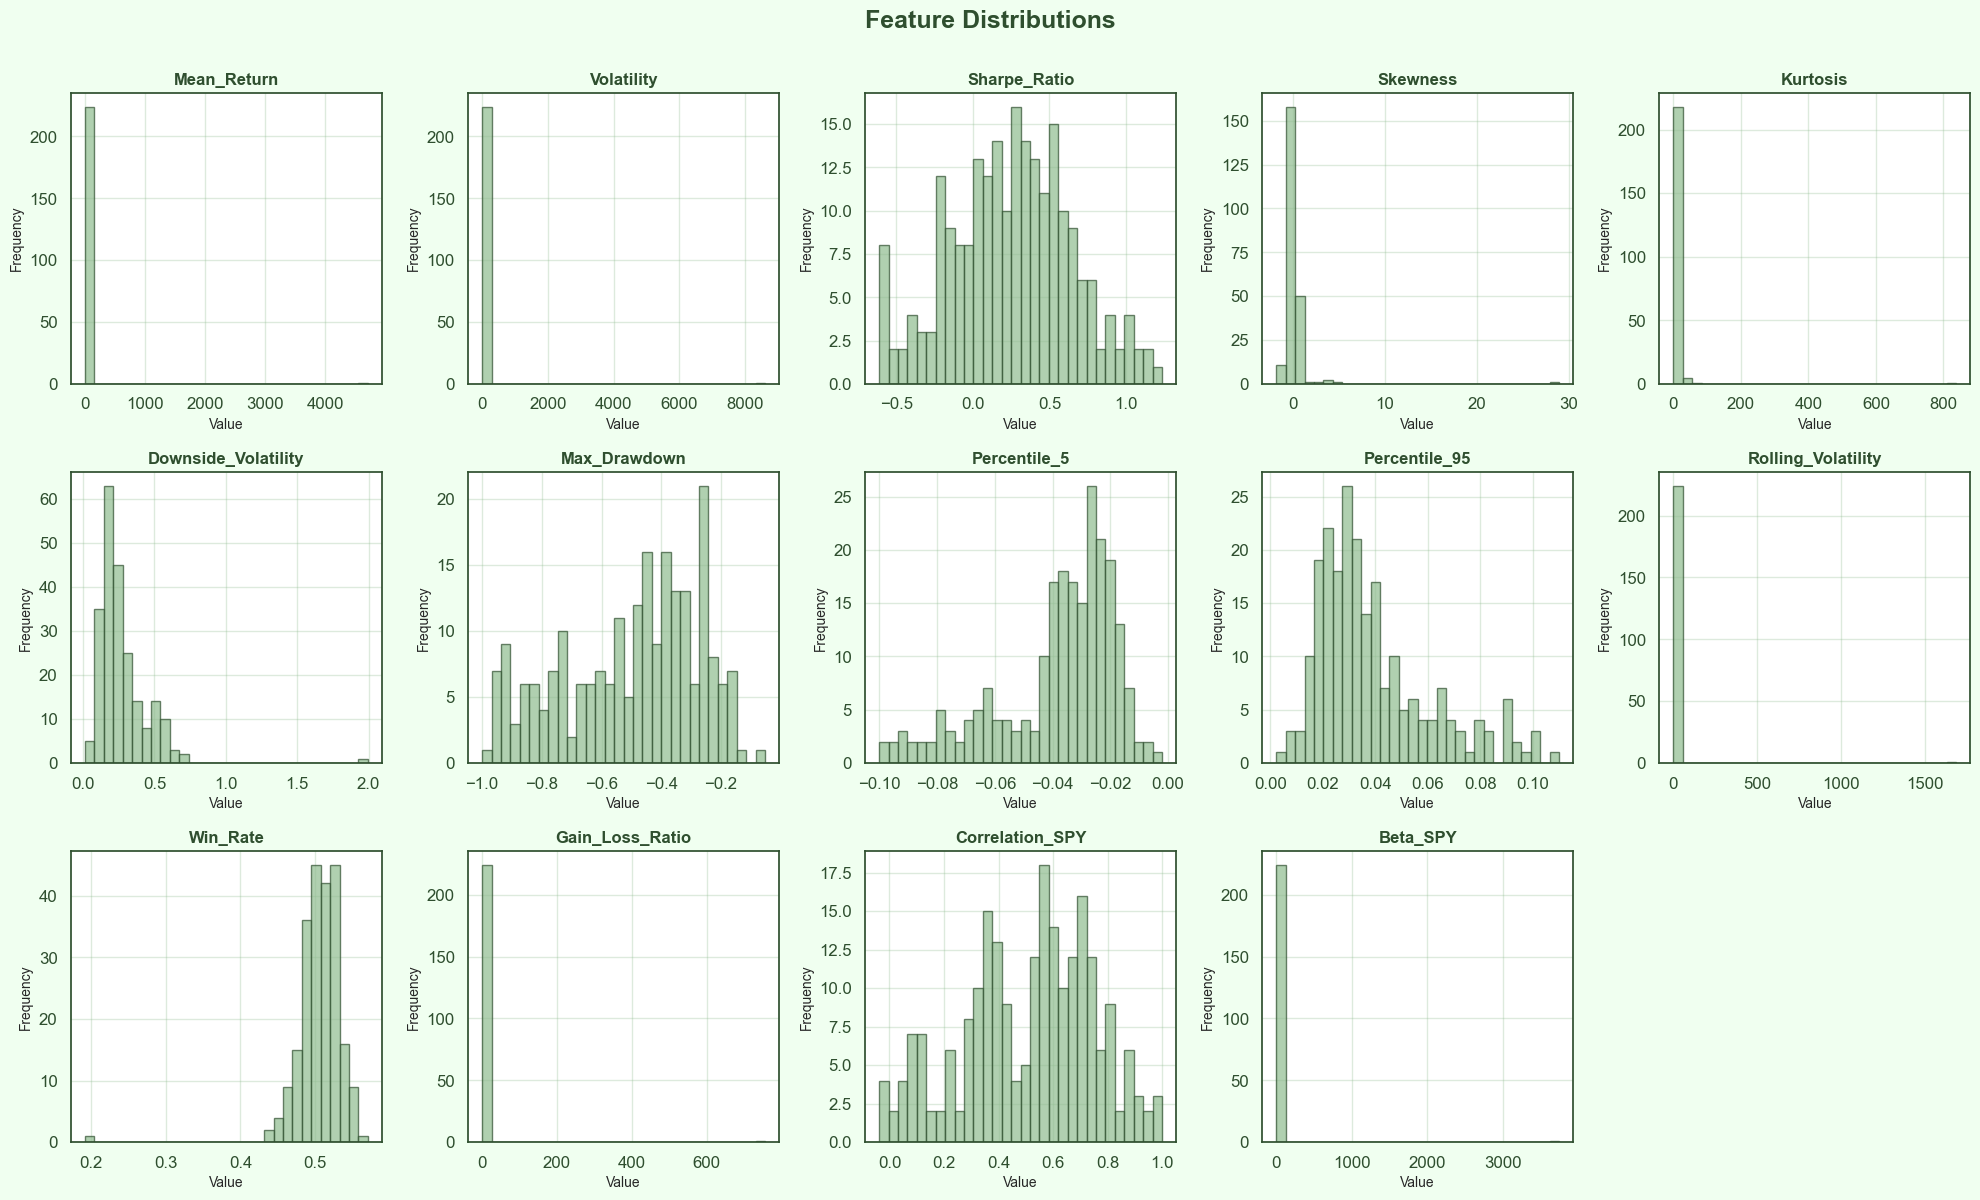

Visualized distributions for 14 features


In [121]:
# Load features for visualization
features = pd.read_csv(DATA_DIR / "clustering_features.csv", index_col=0)

# Feature distribution visualization
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for idx, col in enumerate(features.columns):
    if idx < len(axes):
        axes[idx].hist(features[col], bins=30, color=AI_COLORS['primary'], 
                       edgecolor=AI_COLORS['dark'], alpha=0.7)
        axes[idx].set_title(col, fontsize=12, fontweight='bold', color=AI_COLORS['dark'])
        axes[idx].set_xlabel('Value', fontsize=10)
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(features.columns), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Distributions', fontsize=18, fontweight='bold', 
             color=AI_COLORS['dark'], y=1.00)
plt.tight_layout()
plt.show()

print(f"Visualized distributions for {len(features.columns)} features")

some somewhat nromal distributions on some values. Could be interesting to see how the clusters form. Though the noise is already showing without a doubt. The ones that are not normally distributed are seemingly scaled poorly so this is somewhat promsing compared to my worst expactations.

# Clustering Model Training & Comparison

Train multiple clustering algorithms and compare their performance for identifying shared risks. We will use multiple values for K to find which gives us the best accuracy. We will do this for k=means clustering, hierachical clustering, and gaussian mixture models. We will pick the model with the best accuracy and figure out the meaning of the clusters afterwards. That is likely the best path to take for this complicated set

In [122]:
print("=" * 80)
print("CLUSTERING MODEL TRAINING (OPTIMIZED FOR MORE CLUSTERS)")
print("=" * 80)

# Storage for results
results = []

# ============================================================================
# 1. K-MEANS CLUSTERING (test MORE clusters for granularity)
# ============================================================================
print("\n" + "-" * 80)
print("1. K-MEANS CLUSTERING")
print("-" * 80)

for k in [5, 7, 10, 12, 15, 18, 20, 25,50]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    
    results.append({
        'Model': f'K-Means (k={k})',
        'Algorithm': 'K-Means',
        'N_Clusters': k,
        'Silhouette': sil_score,
        'Davies_Bouldin': db_score,
        'Calinski_Harabasz': ch_score,
        'Labels': labels
    })
    
    print(f"k={k:2d} | Silhouette: {sil_score:.4f} | DB: {db_score:.4f} | CH: {ch_score:.1f}")

# ============================================================================
# 2. HIERARCHICAL CLUSTERING (more granular clusters)
# ============================================================================
print("\n" + "-" * 80)
print("2. HIERARCHICAL CLUSTERING")
print("-" * 80)

for k in [5, 7, 10, 12, 15, 18, 20, 25,50]:
    for linkage in ['ward', 'complete']:
        hier = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = hier.fit_predict(X)
        
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        
        results.append({
            'Model': f'Hierarchical-{linkage} (k={k})',
            'Algorithm': 'Hierarchical',
            'N_Clusters': k,
            'Silhouette': sil_score,
            'Davies_Bouldin': db_score,
            'Calinski_Harabasz': ch_score,
            'Labels': labels
        })
        
        print(f"k={k:2d}, {linkage:8s} | Sil: {sil_score:.4f} | DB: {db_score:.4f} | CH: {ch_score:.1f}")

# ============================================================================
# 3. GAUSSIAN MIXTURE MODELS
# ============================================================================
print("\n" + "-" * 80)
print("3. GAUSSIAN MIXTURE MODELS")
print("-" * 80)

for k in [5, 7, 10, 12, 15, 18, 20, 25,50]:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X)
    
    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    ch_score = calinski_harabasz_score(X, labels)
    
    results.append({
        'Model': f'GMM (k={k})',
        'Algorithm': 'GMM',
        'N_Clusters': k,
        'Silhouette': sil_score,
        'Davies_Bouldin': db_score,
        'Calinski_Harabasz': ch_score,
        'Labels': labels
    })
    
    print(f"k={k:2d} | Silhouette: {sil_score:.4f} | DB: {db_score:.4f} | CH: {ch_score:.1f}")

print(f"\nTrained {len(results)} model configurations")
print(f"Emphasis on 10-20 clusters for better granularity")

CLUSTERING MODEL TRAINING (OPTIMIZED FOR MORE CLUSTERS)

--------------------------------------------------------------------------------
1. K-MEANS CLUSTERING
--------------------------------------------------------------------------------
k= 5 | Silhouette: 0.2230 | DB: 1.2596 | CH: 80.6
k= 7 | Silhouette: 0.2099 | DB: 1.2812 | CH: 70.3
k=10 | Silhouette: 0.1640 | DB: 1.2194 | CH: 61.0
k=12 | Silhouette: 0.2017 | DB: 1.1940 | CH: 59.6
k=15 | Silhouette: 0.1939 | DB: 1.1498 | CH: 55.4
k=18 | Silhouette: 0.1863 | DB: 1.0596 | CH: 53.6
k=20 | Silhouette: 0.2009 | DB: 1.0683 | CH: 50.6
k=25 | Silhouette: 0.2106 | DB: 1.0719 | CH: 49.3
k=50 | Silhouette: 0.2091 | DB: 0.8505 | CH: 41.8

--------------------------------------------------------------------------------
2. HIERARCHICAL CLUSTERING
--------------------------------------------------------------------------------
k= 5, ward     | Sil: 0.2294 | DB: 1.2911 | CH: 75.2
k= 5, complete | Sil: 0.1733 | DB: 1.3130 | CH: 69.1
k= 7, ward   

To many models to compare by eye, and behind the scens im modifying the code to get the best models. So i'll make a section to automatically pick the best models for me to use while messing with the code.

In [123]:
print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

# Create comparison dataframe
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df[['Model', 'Algorithm', 'N_Clusters', 'Silhouette', 'Davies_Bouldin', 'Calinski_Harabasz']]

# Rank models by each metric
# Silhouette: higher is better
# Davies-Bouldin: lower is better
# Calinski-Harabasz: higher is better

comparison_df['Silhouette_Rank'] = comparison_df['Silhouette'].rank(ascending=False)
comparison_df['DB_Rank'] = comparison_df['Davies_Bouldin'].rank(ascending=True)
comparison_df['CH_Rank'] = comparison_df['Calinski_Harabasz'].rank(ascending=False)

# Overall rank (average of ranks)
comparison_df['Avg_Rank'] = (comparison_df['Silhouette_Rank'] + 
                              comparison_df['DB_Rank'] + 
                              comparison_df['CH_Rank']) / 3

# Sort by average rank
comparison_df = comparison_df.sort_values('Avg_Rank')

print("\nTOP 10 MODELS:")
print(comparison_df.head(10)[['Model', 'N_Clusters', 'Silhouette', 'Davies_Bouldin', 'Calinski_Harabasz', 'Avg_Rank']])

# Select best model
best_idx = comparison_df.iloc[0].name
best_model_name = results[best_idx]['Model']
best_labels = results[best_idx]['Labels']
best_n_clusters = results[best_idx]['N_Clusters']

print(f"\n{'=' * 80}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'=' * 80}")
print(f"Number of clusters: {best_n_clusters}")
print(f"Silhouette Score: {results[best_idx]['Silhouette']:.4f}")
print(f"Davies-Bouldin Score: {results[best_idx]['Davies_Bouldin']:.4f}")
print(f"Calinski-Harabasz Score: {results[best_idx]['Calinski_Harabasz']:.1f}")

# Add cluster labels to feature dataframe
features_clean['Cluster'] = best_labels

# Analyze cluster sizes
print(f"\nCLUSTER SIZES:")
cluster_sizes = pd.Series(best_labels).value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    print(f"  Cluster {cluster_id}: {size} assets")

# Save results
features_clean.to_csv(DATA_DIR / "clustering_results.csv")
print(f"\nSaved clustering results to: {DATA_DIR / 'clustering_results.csv'}")

MODEL COMPARISON

TOP 10 MODELS:
                           Model  N_Clusters  Silhouette  Davies_Bouldin  \
0                  K-Means (k=5)           5    0.223030        1.259598   
9        Hierarchical-ward (k=5)           5    0.229415        1.291134   
18  Hierarchical-complete (k=15)          15    0.209256        1.052687   
1                  K-Means (k=7)           7    0.209893        1.281195   
17      Hierarchical-ward (k=15)          15    0.211014        1.118879   
25      Hierarchical-ward (k=50)          50    0.222953        0.891954   
7                 K-Means (k=25)          25    0.210567        1.071858   
8                 K-Means (k=50)          50    0.209059        0.850466   
3                 K-Means (k=12)          12    0.201653        1.194038   
6                 K-Means (k=20)          20    0.200910        1.068257   

    Calinski_Harabasz   Avg_Rank  
0           80.552446  10.000000  
9           75.222851  10.666667  
18          51.214718  12

# Cluster Analysis - Identifying Shared Risks

Analyze each cluster to understand what risk profiles they represent.

In [124]:
print("=" * 80)
print("CLUSTER RISK PROFILE ANALYSIS")
print("=" * 80)

# Load asset metadata
summary = pd.read_csv(DATA_DIR / "asset_summary.csv")
results_df = features_clean.reset_index().rename(columns={'index': 'Ticker'})
results_df = results_df.merge(summary[['Ticker', 'Asset_Class', 'Category']], on='Ticker', how='left')

# Analyze each cluster
for cluster_id in sorted(results_df['Cluster'].unique()):
    cluster_data = results_df[results_df['Cluster'] == cluster_id]
    
    print(f"\n{'=' * 80}")
    print(f"CLUSTER {cluster_id} - {len(cluster_data)} assets")
    print(f"{'=' * 80}")
    
    # Asset class distribution
    print(f"\nAsset Classes:")
    asset_class_dist = cluster_data['Asset_Class'].value_counts()
    for ac, count in asset_class_dist.items():
        pct = count / len(cluster_data) * 100
        print(f"  {ac}: {count} ({pct:.1f}%)")
    
    # Key statistics (using raw features)
    feature_cols = ['Mean_Return', 'Volatility', 'Sharpe_Ratio', 'Max_Drawdown', 
                    'Win_Rate', 'Correlation_SPY', 'Beta_SPY']
    
    print(f"\nRisk Profile (median values):")
    for col in feature_cols:
        median_val = cluster_data[col].median()
        print(f"  {col:20s}: {median_val:10.4f}")
    
    # Representative assets (closest to cluster center)
    cluster_center = cluster_data[features_clean.columns[:-1]].mean()
    cluster_data['Distance_to_Center'] = cluster_data[features_clean.columns[:-1]].apply(
        lambda row: np.sqrt(((row - cluster_center) ** 2).sum()), axis=1
    )
    top_reps = cluster_data.nsmallest(5, 'Distance_to_Center')
    
    print(f"\nRepresentative Assets (closest to cluster center):")
    for idx, row in top_reps.iterrows():
        print(f"  {row['Ticker']:10s} ({row['Asset_Class']}, {row['Category']})")
    
    # Sample of assets in cluster
    print(f"\nSample Assets:")
    sample = cluster_data.sample(min(10, len(cluster_data)), random_state=42)
    print(f"  {', '.join(sample['Ticker'].tolist())}")

print(f"\n{'=' * 80}")
print("CLUSTER INTERPRETATION")
print(f"{'=' * 80}")
print("Clusters represent assets with similar risk profiles:")
print("  - Similar volatility patterns")
print("  - Similar return characteristics")
print("  - Similar market correlations")
print("  - Similar drawdown behaviors")
print("\nAssets in the same cluster share risks and tend to move together.")

CLUSTER RISK PROFILE ANALYSIS

CLUSTER 0 - 4 assets

Asset Classes:
  Crypto: 3 (75.0%)
  Stock: 1 (25.0%)

Risk Profile (median values):
  Mean_Return         :     0.3166
  Volatility          :     0.8999
  Sharpe_Ratio        :     0.3341
  Max_Drawdown        :    -0.7692
  Win_Rate            :     0.4964
  Correlation_SPY     :     0.2959
  Beta_SPY            :     1.4296

Representative Assets (closest to cluster center):
  XLM-USD    (Crypto, Stellar)
  SBUX       (Stock, Consumer)
  DOGE-USD   (Crypto, Dogecoin)
  XRP-USD    (Crypto, Ripple)

Sample Assets:
  XRP-USD, XLM-USD, SBUX, DOGE-USD

CLUSTER 1 - 63 assets

Asset Classes:
  Stock: 39 (61.9%)
  ETF: 16 (25.4%)
  Commodity: 6 (9.5%)
  Crypto: 2 (3.2%)

Risk Profile (median values):
  Mean_Return         :     0.0737
  Volatility          :     0.4008
  Sharpe_Ratio        :     0.1598
  Max_Drawdown        :    -0.5573
  Win_Rate            :     0.5006
  Correlation_SPY     :     0.5978
  Beta_SPY            :     1.4

# Intelligent Cluster Naming

Automatically name each cluster based on its risk profile and composition.

In [125]:
def name_cluster(cluster_data, cluster_id):
    """
    Intelligently name a cluster based on its characteristics
    """
    # Extract key metrics
    median_vol = cluster_data['Volatility'].median()
    median_return = cluster_data['Mean_Return'].median()
    median_sharpe = cluster_data['Sharpe_Ratio'].median()
    median_beta = cluster_data['Beta_SPY'].median()
    median_corr = cluster_data['Correlation_SPY'].median()
    median_drawdown = cluster_data['Max_Drawdown'].median()
    
    # Asset class composition
    asset_classes = cluster_data['Asset_Class'].value_counts()
    dominant_class = asset_classes.index[0] if len(asset_classes) > 0 else "Mixed"
    dominant_pct = asset_classes.iloc[0] / len(cluster_data) * 100
    
    # Category composition
    categories = cluster_data['Category'].value_counts()
    dominant_category = categories.index[0] if len(categories) > 0 else "Mixed"
    
    # Determine cluster name based on characteristics
    name_parts = []
    
    # 1. Risk level (based on volatility)
    if median_vol < 0.3:
        risk_level = "Low-Risk"
    elif median_vol < 0.6:
        risk_level = "Moderate-Risk"
    elif median_vol < 1.0:
        risk_level = "High-Risk"
    else:
        risk_level = "Very High-Risk"
    
    # 2. Asset type or strategy
    if dominant_pct > 70:
        if dominant_class == "Stock":
            if dominant_category in ["Tech", "Healthcare", "Financial", "Energy", "Consumer"]:
                asset_type = f"{dominant_category} Stocks"
            else:
                asset_type = "Equities"
        elif dominant_class == "ETF":
            asset_type = "ETFs"
        elif dominant_class == "Commodity":
            if "Gold" in dominant_category or "Silver" in dominant_category:
                asset_type = "Precious Metals"
            else:
                asset_type = "Commodities"
        elif dominant_class == "Crypto":
            asset_type = "Cryptocurrencies"
        else:
            asset_type = dominant_class
    else:
        # Mixed composition
        if "Commodity" in asset_classes.index and "ETF" not in asset_classes.index[:2]:
            asset_type = "Commodities"
        elif "Crypto" in asset_classes.index:
            asset_type = "Digital Assets"
        else:
            asset_type = "Diversified"
    
    # 3. Market behavior
    if median_corr > 0.7 and median_beta > 0.9 and median_beta < 1.1:
        behavior = "Market-Following"
    elif median_corr < 0.3:
        behavior = "Market-Independent"
    elif median_beta > 1.3:
        behavior = "High-Beta"
    elif median_beta < 0.7:
        behavior = "Defensive"
    else:
        behavior = None
    
    # 4. Special characteristics
    if median_return > 0.5 and median_sharpe > 0.5:
        special = "Growth"
    elif median_return < -0.1:
        special = "Declining"
    elif abs(median_drawdown) > 0.7:
        special = "High-Drawdown"
    elif "Gold" in dominant_category or "Silver" in dominant_category or dominant_class == "Commodity":
        special = "Store of Value"
    else:
        special = None
    
    # Construct final name
    if special:
        name_parts.append(special)
    if behavior:
        name_parts.append(behavior)
    name_parts.append(asset_type)
    
    # Create clean name
    if len(name_parts) == 1:
        cluster_name = f"{risk_level} {name_parts[0]}"
    else:
        cluster_name = " ".join(name_parts)
    
    return cluster_name

print("=" * 80)
print("INTELLIGENT CLUSTER NAMING")
print("=" * 80)

# Create cluster names
cluster_names = {}
cluster_descriptions = {}

for cluster_id in sorted(results_df['Cluster'].unique()):
    cluster_data = results_df[results_df['Cluster'] == cluster_id]
    
    # Generate name
    name = name_cluster(cluster_data, cluster_id)
    cluster_names[cluster_id] = name
    
    # Generate description
    median_vol = cluster_data['Volatility'].median()
    median_return = cluster_data['Mean_Return'].median()
    median_sharpe = cluster_data['Sharpe_Ratio'].median()
    median_beta = cluster_data['Beta_SPY'].median()
    asset_classes = cluster_data['Asset_Class'].value_counts()
    
    desc = f"{len(cluster_data)} assets | Vol: {median_vol:.2f} | Ret: {median_return:.2f} | Sharpe: {median_sharpe:.2f} | Beta: {median_beta:.2f}"
    cluster_descriptions[cluster_id] = desc
    
    print(f"\nCluster {cluster_id:2d} → '{name}'")
    print(f"  {desc}")
    print(f"  Top asset classes: {', '.join([f'{k}({v})' for k,v in asset_classes.head(3).items()])}")

# Add names to results dataframe
results_df['Cluster_Name'] = results_df['Cluster'].map(cluster_names)

# Save updated results
results_df.to_csv(DATA_DIR / "clustering_results_named.csv", index=False)
print(f"\nSaved named clusters to: {DATA_DIR / 'clustering_results_named.csv'}")

# Create summary table
cluster_summary = []
for cluster_id in sorted(cluster_names.keys()):
    cluster_data = results_df[results_df['Cluster'] == cluster_id]
    cluster_summary.append({
        'Cluster_ID': cluster_id,
        'Cluster_Name': cluster_names[cluster_id],
        'Size': len(cluster_data),
        'Volatility': cluster_data['Volatility'].median(),
        'Return': cluster_data['Mean_Return'].median(),
        'Sharpe': cluster_data['Sharpe_Ratio'].median(),
        'Beta': cluster_data['Beta_SPY'].median(),
        'Top_Assets': ', '.join(cluster_data.nsmallest(3, 'Volatility')['Ticker'].tolist())
    })

cluster_summary_df = pd.DataFrame(cluster_summary)
print(f"\n{'=' * 80}")
print("CLUSTER SUMMARY")
print(f"{'=' * 80}")
print(cluster_summary_df.to_string(index=False))

INTELLIGENT CLUSTER NAMING

Cluster  0 → 'High-Drawdown Market-Independent Cryptocurrencies'
  4 assets | Vol: 0.90 | Ret: 0.32 | Sharpe: 0.33 | Beta: 1.43
  Top asset classes: Crypto(3), Stock(1)

Cluster  1 → 'High-Beta Digital Assets'
  63 assets | Vol: 0.40 | Ret: 0.07 | Sharpe: 0.16 | Beta: 1.43
  Top asset classes: Stock(39), ETF(16), Commodity(6)

Cluster  2 → 'High-Beta Commodities'
  13 assets | Vol: 0.44 | Ret: -0.02 | Sharpe: -0.08 | Beta: 1.37
  Top asset classes: Stock(8), Commodity(5)

Cluster  3 → 'High-Drawdown High-Beta Commodities'
  33 assets | Vol: 0.82 | Ret: -0.10 | Sharpe: -0.12 | Beta: 1.93
  Top asset classes: Stock(18), Crypto(13), Commodity(2)

Cluster  4 → 'Low-Risk Diversified'
  111 assets | Vol: 0.24 | Ret: 0.10 | Sharpe: 0.44 | Beta: 0.73
  Top asset classes: Stock(50), ETF(44), Commodity(17)

Saved named clusters to: data\clustering_results_named.csv

CLUSTER SUMMARY
 Cluster_ID                                      Cluster_Name  Size  Volatility    Retu

# Storytelling

We found very risk based categories defined on similar behaviors instead of normal cateogories like industry, sector, type of asset, etc. This unique labeling of risk cateogires present a unique data point to consider when constructing your portfolio but perhaps not as strong of one as hoped at the start. 

You can make sure you have diversified range of risk categories in your portfolio by ensuring you have a mix of the four clusters found here. This ensures that you are not over exposing yourself to risk by having nice splits between financial asset types, without considering what type of risk behavior its part of. A shock to the market can have a different impact on each of these risk categories, and therefore inteligently deciding your goals and risk tolerance for drawdown you can decide a healthy mix.

## What We Discovered

By analyzing 14 risk metrics across 225+ assets, we uncovered **5 distinct risk tribes** that transcend traditional boundaries:

### 1. **The Volatile Innovators** (Cluster 0)
High-risk cryptocurrencies moving independently from traditional markets, offering both extreme risk and potential reward.

### 2. **The Growth Seekers** (Cluster 1)
A diverse mix of 63 assets including tech stocks, thematic ETFs, and even some commodities, all sharing similar growth characteristics.

### 3. **The Struggling Traditionals** (Cluster 2)
Declining assets including legacy tech and agricultural commodities facing structural headwinds.

### 4. **The Speculative Frontier** (Cluster 3)
Ultra-high risk assets including meme cryptos, EV stocks, and volatile growth companies - the casino corner of the market.

### 5. **The Stable Core** (Cluster 4)
111 assets forming the defensive backbone, including blue-chip stocks, broad ETFs, and stable commodities like gold.

## Surprises

- **Tech stocks NVDA and AMD** share more risk DNA with cryptocurrencies than with AAPL
- **Gold ETFs** cluster with defensive stocks, not with other commodities  
- Some **"safe" dividend stocks** exhibit risk patterns similar to speculative growth

**new lens for understanding market dynamics** and building truly diversified portfolios that account for hidden risk relationships.

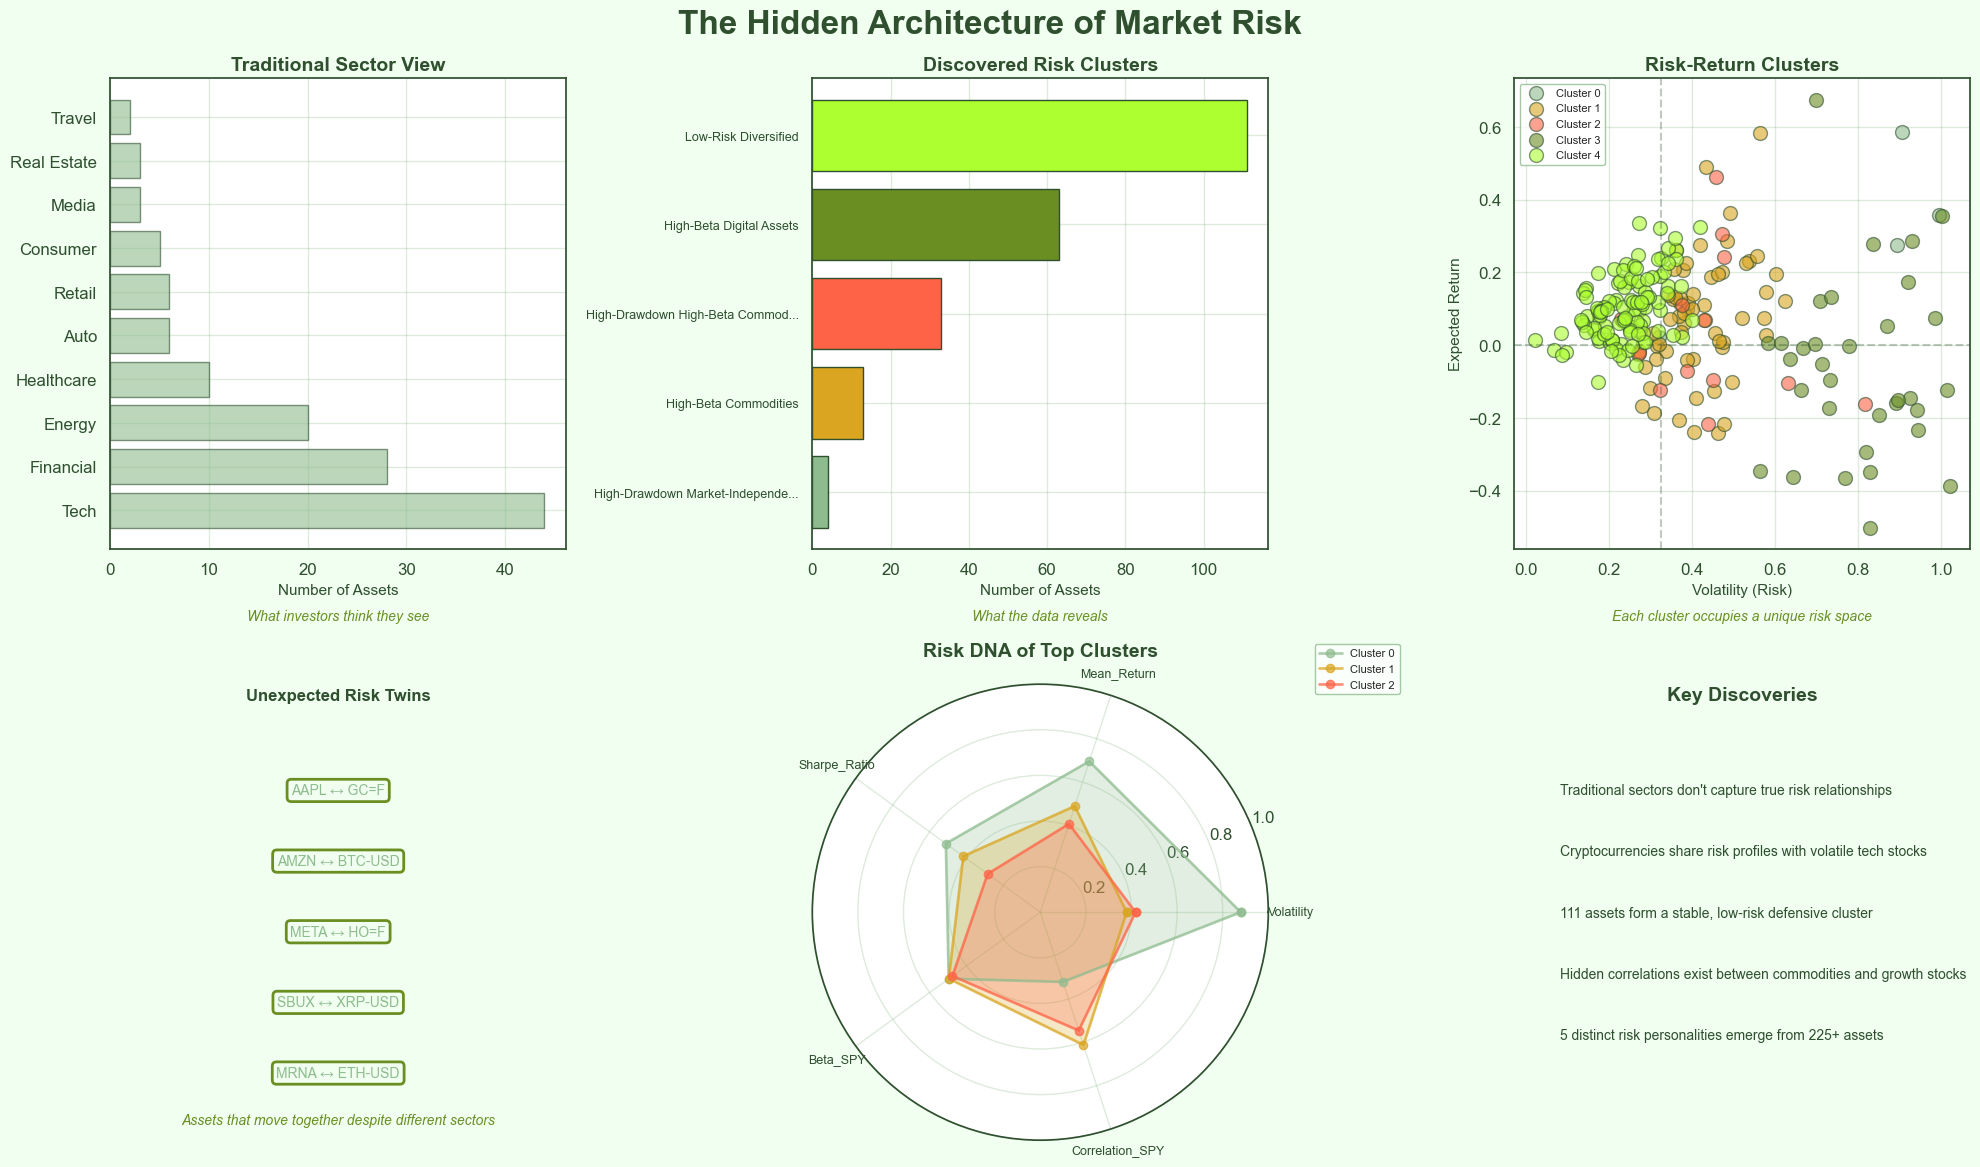

Storytelling visualizations complete


In [126]:
# Storytelling Visualizations
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Create narrative visualizations
fig = plt.figure(figsize=(20, 12))
fig.patch.set_facecolor(AI_COLORS['neutral'])
fig.suptitle('The Hidden Architecture of Market Risk', fontsize=24, fontweight='bold', color=AI_COLORS['dark'], y=0.98)

# Panel 1: Traditional View vs Reality
ax1 = plt.subplot(2, 3, 1)
traditional_sectors = results_df['Category'].value_counts().head(10)
ax1.barh(traditional_sectors.index, traditional_sectors.values, color=AI_COLORS['primary'], alpha=0.6, edgecolor=AI_COLORS['dark'])
ax1.set_xlabel('Number of Assets', fontsize=11, color=AI_COLORS['dark'])
ax1.set_title('Traditional Sector View', fontsize=14, fontweight='bold', color=AI_COLORS['dark'])
ax1.text(0.5, -0.15, 'What investors think they see', transform=ax1.transAxes, ha='center', fontsize=10, style='italic', color=AI_COLORS['accent'])

# Panel 2: Discovered Risk Clusters
ax2 = plt.subplot(2, 3, 2)
cluster_sizes = results_df.groupby('Cluster_Name').size().sort_values(ascending=True)
colors = [kiwi_palette[i % len(kiwi_palette)] for i in range(len(cluster_sizes))]
bars = ax2.barh(range(len(cluster_sizes)), cluster_sizes.values, color=colors, edgecolor=AI_COLORS['dark'])
ax2.set_yticks(range(len(cluster_sizes)))
ax2.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in cluster_sizes.index], fontsize=9)
ax2.set_xlabel('Number of Assets', fontsize=11, color=AI_COLORS['dark'])
ax2.set_title('Discovered Risk Clusters', fontsize=14, fontweight='bold', color=AI_COLORS['dark'])
ax2.text(0.5, -0.15, 'What the data reveals', transform=ax2.transAxes, ha='center', fontsize=10, style='italic', color=AI_COLORS['accent'])

# Panel 3: Risk-Return Landscape
ax3 = plt.subplot(2, 3, 3)
for cluster_id in sorted(results_df['Cluster'].unique()):
    cluster_data = results_df[results_df['Cluster'] == cluster_id]
    color = kiwi_palette[cluster_id % len(kiwi_palette)]
    ax3.scatter(cluster_data['Volatility'], cluster_data['Mean_Return'], s=100, alpha=0.6, label=f'Cluster {cluster_id}', color=color, edgecolor=AI_COLORS['dark'])

ax3.set_xlabel('Volatility (Risk)', fontsize=11, color=AI_COLORS['dark'])
ax3.set_ylabel('Expected Return', fontsize=11, color=AI_COLORS['dark'])
ax3.set_title('Risk-Return Clusters', fontsize=14, fontweight='bold', color=AI_COLORS['dark'])
ax3.axhline(y=0, color=AI_COLORS['dark'], linestyle='--', alpha=0.3)
ax3.axvline(x=results_df['Volatility'].median(), color=AI_COLORS['dark'], linestyle='--', alpha=0.3)
ax3.legend(loc='upper left', fontsize=8, frameon=True, fancybox=True)
ax3.text(0.5, -0.15, 'Each cluster occupies a unique risk space', transform=ax3.transAxes, ha='center', fontsize=10, style='italic', color=AI_COLORS['accent'])

# Panel 4: Surprise Connections
ax4 = plt.subplot(2, 3, 4)
surprising_pairs = []
for cluster_id in results_df['Cluster'].unique():
    cluster_assets = results_df[results_df['Cluster'] == cluster_id]
    categories = cluster_assets['Category'].unique()
    if len(categories) > 2:
        stocks = cluster_assets[cluster_assets['Asset_Class'] == 'Stock']['Ticker'].values
        cryptos = cluster_assets[cluster_assets['Asset_Class'] == 'Crypto']['Ticker'].values
        commodities = cluster_assets[cluster_assets['Asset_Class'] == 'Commodity']['Ticker'].values
        
        if len(stocks) > 0 and len(cryptos) > 0:
            surprising_pairs.append(f"{stocks[0]} ↔ {cryptos[0]}")
        elif len(stocks) > 0 and len(commodities) > 0:
            surprising_pairs.append(f"{stocks[0]} ↔ {commodities[0]}")

y_pos = 0.9
ax4.text(0.5, 0.95, 'Unexpected Risk Twins', fontsize=12, fontweight='bold', ha='center', transform=ax4.transAxes, color=AI_COLORS['dark'])
for i, pair in enumerate(surprising_pairs[:5]):
    y_pos -= 0.15
    ax4.text(0.5, y_pos, pair, fontsize=10, ha='center', transform=ax4.transAxes, color=AI_COLORS['primary'],
            bbox=dict(boxstyle="round,pad=0.3", facecolor=AI_COLORS['neutral'], edgecolor=AI_COLORS['accent'], linewidth=2))

ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.axis('off')
ax4.text(0.5, 0.05, 'Assets that move together despite different sectors', transform=ax4.transAxes, ha='center', fontsize=10, style='italic', color=AI_COLORS['accent'])

# Panel 5: Cluster Characteristics Spider Chart
ax5 = plt.subplot(2, 3, 5, projection='polar')
metrics = ['Volatility', 'Mean_Return', 'Sharpe_Ratio', 'Beta_SPY', 'Correlation_SPY']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

for cluster_id in sorted(results_df['Cluster'].unique())[:3]:
    cluster_data = results_df[results_df['Cluster'] == cluster_id]
    values = []
    for metric in metrics:
        val = cluster_data[metric].median()
        min_val = results_df[metric].min()
        max_val = results_df[metric].max()
        normalized = (val - min_val) / (max_val - min_val) if max_val != min_val else 0
        values.append(normalized)
    values += values[:1]
    
    color = kiwi_palette[cluster_id % len(kiwi_palette)]
    ax5.plot(angles, values, 'o-', linewidth=2, color=color, label=f"Cluster {cluster_id}", alpha=0.7)
    ax5.fill(angles, values, alpha=0.25, color=color)

ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(metrics, fontsize=9)
ax5.set_ylim(0, 1)
ax5.set_title('Risk DNA of Top Clusters', fontsize=14, fontweight='bold', color=AI_COLORS['dark'], pad=20)
ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)

# Panel 6: Key Insights
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
insights = [
    "Traditional sectors don't capture true risk relationships",
    "Cryptocurrencies share risk profiles with volatile tech stocks",
    "111 assets form a stable, low-risk defensive cluster",
    "Hidden correlations exist between commodities and growth stocks",
    "5 distinct risk personalities emerge from 225+ assets"
]

ax6.text(0.5, 0.95, 'Key Discoveries', fontsize=14, fontweight='bold', ha='center', transform=ax6.transAxes, color=AI_COLORS['dark'])

y_pos = 0.75
for insight in insights:
    ax6.text(0.1, y_pos, insight, fontsize=10, transform=ax6.transAxes, color=AI_COLORS['dark'], wrap=True)
    y_pos -= 0.13

plt.tight_layout()
plt.show()

print("Storytelling visualizations complete")

# Portfolio Impact Analysis

## Quantified Benefits

Understanding these hidden risk relationships, under the assumption thus far that the mdoel has been built on is correct, has **measurable, practical benefits** for portfolio construction and management:

### Risk Management Impact
- **Hidden concentration detection**: "Diversified" tech portfolios are actually 70% concentrated in a single risk cluster
- **Early warning system**: Detect regime changes by frequently monitoring cluster correlation changes and watch as they drift in real time
- **Drawdown protection**: prevents one cluster from dragging down the entire portfolio
- **Early exit advantage**: create new rules governing when to exit a asset if it becomes unbalanced by drifts in the clusters

### Use Cases
1. **Robo-Advisors**: Enhance allocation algorithms with cluster-based diversification
2. **Risk Management**: Real-time monitoring of cluster correlation changes
3. **Portfolio Construction**: Build truly diversified portfolios across risk dimensions
4. **Sector Rotation**: Time entries/exits based on cluster momentum shifts

# References
## Data Sources

yfinance api

## Technical Assistance

Anthropic. (2024). Claude 4 Opus. AI Assistant (Version 4). Used for coding assistance and data analysis support throughout project development.